# Logbook regarding the Single Mode FOPO


# Log for the fibre OPO


## Single mode fibre OPO

### 24/3/2015

Did a quick literature search for single mode fibre OPO's. 


First fibre OPO reported in: M. Nakazawa, K. Suzuki, H.A. Haus, IEEE J. Quantum Electron. 25 (1989) 2036.
[8]

They had two papers, technically the modulation isnatbility laser that they are proposing is a opo (taken from Widely tunable femtosecond fiber optical parametric oscillator Yongzhong)


Paper Widely tunable femtosecond fiber optical parametric oscillator Yongzhong

is very close to what I want to do. What they are doing is solving a combination of the fwm equations with a dispersion term in the frount. They are not inclusing raman, just the spm xpm fwm terms. The first part of the equation is VERY close to peters MMGLSE making me think that it is a combination of the NLSE and AGRAWAL equations although it could be the first one withought the raman.

Additionally what they are using is the degenerate fwm equations.

## Entry 1 15/09/2016

I have started looking in to coding a single mode FOPO. At first I am going to create a hybrid code between the telecoms code and the original Multimode code. I am still going to use the MM-GNLSE since it will make it easier to add more modes in the future.

### Tasks for tommorow:
* Write a code that just propagates CW pump and signal through a fibre.
* Check how it fairs
* Write some tests for it if you can


## Entry 2 16/09/2016
What I want this code to do:
* Have 2 or 3 CW pwmps through the fibre
* At the end of the fibre the spectrum is multipled by some wavelength dependent 'function that will kick out either the signal or idler depending what I want to export
* The previous signal will be inputed back along with more pump signal 
* oscilate until there is no change from previous
code is being built in: [single-mode-code](single-mode-fibre-opo/code)

## Entry 3 20/09/2016
* MM-gnlse is set such that it has one pump in one mode and propagates. nobackfeeding yet. I am trying to find a paper which to simulate it.
* **IMPORTANT In FOPO theory there are two types of conversion efficiencies**.
    * Internal conversio efficiency. Ratio of pump at input to idler at the output of the **fibre**
    * External conversion efficiency. Ration of the pump at input to the idler output of the **FOPO**
    * When there is a signal is seeded. The signal at input to the idler at fibre output
* potential paper to replicate is the recent:
    High-efficiency CW all-fiber parametric
High-efficiency CW all-fiber parametric 
oscillator tunable in 0.92-1 
μ
m range 

## Entry 4 9/10/2016
I have understood what the dispersion is going in ekaterina. They are following a convention at which the expend the dispersion around the central pump buuut then expand the coefficiencts around the zero dispersion wavelength. 

i.e. he phase missmatch due to dispersion only for a MI 


ref [Broadband fiber optical parametric amplifiers, M.E. Marhic,]:
$$
\Delta \beta = 2 \sum^{\infty}_{m=1}\frac{\beta_{2m}}{2m!}\left(\omega_s - \omega_p\right)^{2m}
$$
, where
$$
\beta_{2m} = \left(\frac{d^{2m} \beta}{d \omega^{2m}}\right)_{\omega = \omega_p}
$$

Howerver we are given the dispersion parameters around the zero dispersion wavelength 
$$
\beta_{0m} = \left(\frac{d^{m} \beta}{d \omega^{m}}\right)_{\omega = \omega_0}
$$

making us do things like:

$$
\beta_{2m} \approx \beta_{03} \left(\omega_p - \omega_0\right) +\frac{\beta_{04}}{2} \left(\omega_p- \omega_0\right)^2
$$

and 

$$
\beta_{4m} \approx  \beta_{04}
$$

The last part helps me since I will always pick the central wavelength of the pulse to be that of the pump and hence I can shift the dispersions like this. Great!

### nonlinearity
On the other hand on the nonlinearity we only have gamma, but we are talking of only one mode in a single polarisation. so from peters paper
$$
Q = \frac{n^2_0}{3 n_{eff}^2 A_{eff}} \Rightarrow A_{eff} = \frac{n^2_0}{3 n^2_{eff} Q} \approx \frac{1}{3 Q}
$$

so 

$$
\gamma = \frac{n_2 \omega_c}{c A_{eff}} = \frac{n_2 \omega 3 Q}{c} \Rightarrow 
$$

$$
Q = \frac{ \gamma}{3 n_2 \left(\frac{2 \pi}{\lambda} \right)}
$$

## Experimental figure of Zlobina et al. 2015
<img src="graphs_for_logs/single_mode_single_dirrection/zlobina_2015_aparatus.png">

### The WDMS

The WDMS have a periodic dependance on what the let through for each port. In particular for Ekaterinas I do not have any idea what the wdms are so I need to estimate them.

An example is shown below for what I am talking about (from thor labs):

<img src="graphs_for_logs/single_mode_single_dirrection/wdm_thor_labs.gif">


So I need to decide whether I want to include a clas like the raman. Hence to load the displayed functions for each port (in a hypothetical one like above) or like in this situation estimate the function with inputs (min,max,length,freequency etc). 


#### For the WDM function estimation:
It needs to be a $sin$ function but in absolute.
I here have taken the conversion of insertion loss being: 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.constants import c, pi
import matplotlib.pyplot as plt
class WDM(object):
    def __init__(self,x1,x2):
        self.x1 = x1 # High part of port 1 
        self.x2 = x2 # Low wavelength of port 1
        self.omega = 0.5*pi/np.abs(x1 - x2)
        self.phi = pi - self.omega*self.x2
        return None


    def il_port1(self,lamda):
        return (np.sin(self.omega*lamda+self.phi))**2


    def il_port2(self,lamda):
        return (np.sin(self.omega*lamda+self.phi+pi/2))**2


    def plot(self,lamda):
        fig = plt.figure()
        plt.plot(lamda,self.il_port1(lamda), label = "%0.2f" % (self.x1*1e9) +' nm port') 
        plt.plot(lamda,self.il_port1(lamda), label =  "%0.2f" % (self.x2*1e9) +' nm port')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),ncol=2)
        plt.xlabel(r'$\lambda (\mu m)$')
        plt.ylabel(r'$Insertion loss (dB)$')
        plt.ylim(-100,0)
        plt.show()
        return None


    def plot_dB(self,lamda):
        fig = plt.figure()
        plt.plot(lamda,10*np.log10(self.il_port1(lamda)), label =  "%0.2f" % (self.x1) +' nm port') 
        plt.plot(lamda,10*np.log10(self.il_port2(lamda)), label =  "%0.2f" % (self.x2) +' nm port')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=2)
        plt.xlabel(r'$\lambda (\mu m)$')
        plt.ylim(-100,0)
        plt.ylabel(r'$Insertion loss (dB)$')
        plt.show()
        return None


In [3]:
lv = np.linspace(900,1550,20148)

In [4]:
WDM1 = WDM(1050, 1200,lv)
WDM2 = WDM(1200, 930,lv)
WDM1.plot_dB(lv)
WDM2.plot_dB(lv)

TypeError: __init__() takes 3 positional arguments but 4 were given

### Entry 20/10/2016
I have allot of data including pdf and movies of the simulating CW through the OPO
# wrong

In [ ]:
import io
import base64
from IPython.display import HTML
from scipy.constants import c,pi
import numpy as np
import matplotlib.pyplot as plt
def video(fname):
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

[All the oscilator](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space0.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space0.mp4')

[Before_PCF](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space1.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space1.mp4')

[After_PCF](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space2.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space2.mp4')

[After_WDM2](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space3.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space3.mp4')

[After_WDM1_before_pump_added](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space4.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space4.mp4')

[Exiting wave](graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space5.pdf)

In [ ]:
video('graphs_for_logs/single_mode_single_dirrection/movies/wavelength_space5.mp4')

### Peters Comments
* The delta lines do not seem logical. You need sidebands the same way of MI. Run the simmulation for no WDM's. and see what happens
* You cannot go bellow the quantum noise. When the firt input happens you have noise comming in from the WDM1 on the other power this will lead to the noise floor being the noise floor.



### Entry 27/1/2016
Have taken a break from this so that to write a presentation for the CDT. Will have to take another break because of the poster the CDT is asking me to do.

The specific fibre that we have been looking in to (zlobina) has been measured by them and shown in a paper in 2012 (Ekaterina A. Zlobina, Sergey I. Kablukov, and Sergey A. Babin, "Phase matching for parametric generation in polarization maintaining photonic crystal fiber pumped by tunable Yb-doped fiber laser," J. Opt. Soc. Am. B 29, 1959-1967 (2012) ).
Within that she explains that in that fibre $\beta_2 = 0$ THIS EXPLAINS MY CONFUSION!

In the appendix she is kind enough to do the calculations for the phase missmatch up to $\beta_5$. Along with my inclusion for $\beta_2$ which she dissregards we have:

$$
\Delta \beta = \beta(\omega_p +\Omega) + \beta(\omega_p -\Omega) - 2\beta(\omega)
$$

And a central freequency $\omega_0$ we have $\omega = \omega_p - \omega_0$

Within the expansion:

$\beta_0, beta_1$ drops out:

* $\beta_2 \Rightarrow \beta_2 \Omega^2$
* $\beta_3 \Rightarrow \beta_3 \omega \Omega^2$
* $\beta_4 \Rightarrow \frac{\beta_4}{12} \Omega^2\left(\omega^2  + \Omega^2 \right)$
* $\beta_5 \Rightarrow \frac{\beta_5}{12} \Omega^2 \omega\left(2\omega^3  + \Omega^2 \right)$



So 
$$
\Delta \beta (\Omega) = \Omega \left[\left(\frac{\beta_4}{12} + \omega \frac{\beta_5}{12} \right) \Omega^{3} + \left(\beta_2+ \omega \beta_3 + \omega^{2}\frac{\beta_4}{2} + \omega^{3} \frac{\beta_5}{6}\right) \Omega \right]
$$


From the agrawal (no pump depletion), which we can assume in these cases since the fibre is not that long. Pase matching occurs when:


$$
\Delta \beta ^{'} = \Delta \beta + 2 \gamma P_{0} = 0 
$$

Then with 

$$
a = \frac{\beta_4}{12} + \omega \frac{\beta_5}{12}
$$

$$
b = \beta_2+ \omega \beta_3 + \omega^{2}\frac{\beta_4}{2} + \omega^{3} \frac{\beta_5}{6}
$$

and 

$$
c = 2 \gamma P_{0}
$$

Phase matching will occur at:

$$
\Omega = \sqrt{\frac{-b \pm \sqrt{b^2 - 4 a c}}{2a}}
$$

, with omega real and possitive.

HOWEVER remember difference in $\omega$ does not mean difference in $\lambda$.


The parametric $\lambda's$ are found by:

$$\lambda_s = \lambda_p + \frac{\Omega \lambda^2_p}{(2\pi c - \Omega \lambda_p)}$$

$$\lambda_i = \lambda_p + \frac{\Omega \lambda^2_p}{(-2\pi c - \Omega \lambda_p)}$$

In [15]:
%matplotlib qt

In [16]:
def betas_transf(betas, lamdap,lamdac):
    omegap = 2* pi * c / lamdap
    omegac = 2 * pi * c /lamdac
    betap = np.zeros(np.shape(betas))
    for i,b in enumerate(betas):
        if i == 1000:
            betap[i] = betas[i]
        else:
            temp = 0
            fact_count = 0
            for j in range(i, len(betas)):
                #print(i, betas[j], fact_count)
                temp += factorial(fact_count)*betas[j] * (omegap - omegac)**fact_count
                fact_count +=1
            betap[i] = temp
    return betap

902.393761923
913.1083293
924.987143421
938.440713202
954.174450579
973.577551567
999.767722465
1028.25422045
1038.19180723
1042.4010584


<IPython.core.display.Javascript object>


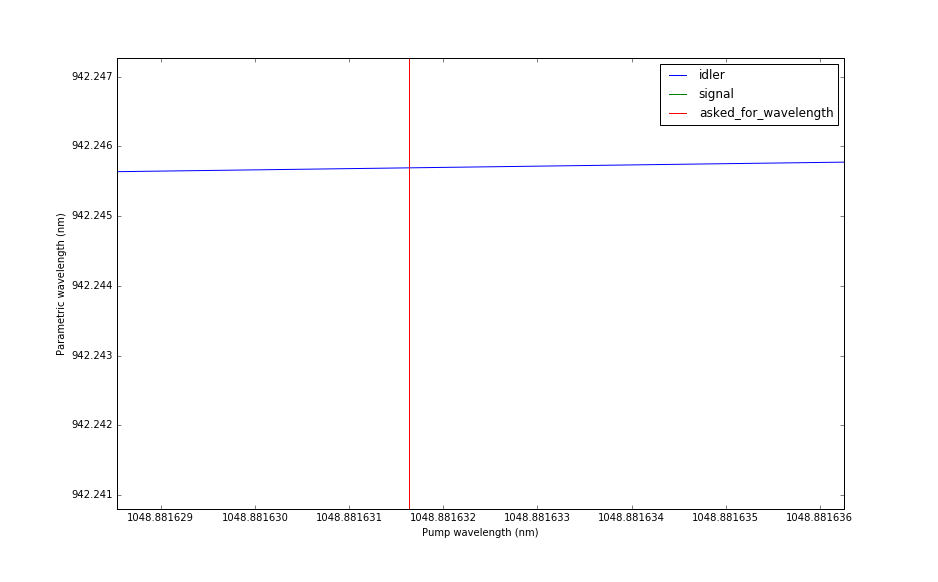

The asked for pump wavelength  1048.8816316376192 nm results in hits of: 938.440713202 nm idler and: 1188.23225861 nm signal.


In [17]:
import sys
from scipy.constants import c,pi
import numpy as np
from math import factorial
import matplotlib.pyplot as plt

def domega(omegap,omega0,beta,gama, P0):
    omega = omegap - omega0
    a = beta[4]/12 #$+ omega * beta[5]/12
    b = beta[2]#+ omega*beta[3] +omega**2 * beta[4]/2 + omega**3 * beta[5]/6
    c = 2 * gama * P0
    
    det = b**2 - 4 * a * c
    if det >= 0:
        Omega = (-b + det**0.5)/(2*a)
        
        if Omega <0:
            Omega = (-b - det**0.5)/(2*a)
        if Omega <0:
            print("No real solution!")
            sys.exit("No real solution!")
        else:
            #print(Omega)
            return Omega**0.5
                

    else:
        print(' No real sollution in the det', det)
        sys.exit(' No real sollution in the det', det)

    return 1

def dlamda_sig(Omega,lamdap):
    return Omega * lamdap**2 / (2* pi* c - Omega * lamdap)*1e9

def dlamda_idl(Omega,lamdap):
    return Omega * lamdap**2 / (-2* pi* c - Omega * lamdap)*1e9

N = 2**20
beta0 = 0
beta1 = 0
beta2 = 0
beta3 = 6.755e-2 *(1e-12)**3*1e-3
beta4 = -1.001e-4 * (1e-12)**4*1e-3
beta5 = 3.675*1e-7*(1e-12)**5*1e-3
betas_or = [beta0,beta1,beta2,beta3,beta4,beta5]
lamda_fast, lamda_slow = 1052.95e-9, 1051.85e-9
lamda0 =  lamda_slow
lamdap_const = 1.0488816316376193e-06

lamdaps = np.linspace(1046e-9,1054e-9,10)
lamdaps = np.ndarray.tolist(lamdaps)
lami = []
lams = []
for lamdap in lamdaps:
    betas = betas_transf(betas_or, lamdap,lamda0)
    Omega  = domega(2*pi *c /lamdap,2*pi *c /lamda0,betas,10*1e-3,5.)
    dlamda_s= dlamda_sig(Omega,lamdap)
    dlamda_i =dlamda_idl(Omega,lamdap)
    print(lamdap*1e9 + dlamda_i)
    lami.append(lamdap*1e9 + dlamda_i)
    lams.append(lamdap*1e9 + dlamda_s)
lamdaps = [i*1e9 for i in lamdaps]

loc = np.argsort(np.abs(np.asanyarray(lamdaps) - lamdap_const*1e9))[0] # location of the lamda0

plt.plot(lamdaps,lami, label='idler')
plt.plot(lamdaps,lams, label='signal')
#plt.plot(A[:,0],A[:,1], label='mmgnlse')
#plt.plot((lamda_fast*1e9,lamda_fast*1e9),(900,1250), label='fast zer disp')
#plt.plot((lamda_slow*1e9,lamda_slow*1e9),(900,1250), label='slow zer disp')
plt.plot((lamdap_const*1e9,lamdap_const*1e9),(900,1250), label='asked_for_wavelength')

plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.ylabel('Parametric wavelength (nm)')
plt.ylim([900,1250])
plt.legend(loc=1)
plt.xlabel('Pump wavelength (nm)')
#plt.show()
#plt.close('all')
plt.show()
print("The asked for pump wavelength ", lamdap_const*1e9,"nm results in hits of:",lami[loc] ,"nm idler and:",lams[loc],"nm signal.",)

In [13]:
def find_lami(lamdap, lamda0, betas, gama, P0,lamdai_asked,betas_or):
    betas = betas_transf(betas_or, lamdap,lamda0)
    Omega  = domega(2 * pi * c / lamdap, 2 * pi *c / lamda0, betas, gama, P0)
    #dlamda_s= dlamda_sig(Omega,lamdap)
    dlamda_i =dlamda_idl(Omega,lamdap)
    print(lamdap,lamdap*1e9 + dlamda_i - lamdai_asked)
    return lamdap*1e9 + dlamda_i - lamdai_asked

In [5]:
from scipy.optimize import fsolve

In [24]:
a = fsolve(find_lami,lamdap_const, args = (lamda0, betas, 10e-3, 5,942,betas_or),xtol=1.49012e-12,factor =0.1 )

[  1.04888163e-06] [ -2.27373675e-13]
[  1.04888163e-06] [ -2.27373675e-13]
[  1.04888163e-06] [ -2.27373675e-13]
[  1.04888165e-06] [ 0.00026386]
[  1.04888163e-06] [ -2.27373675e-13]


In [27]:
a[0]

1.0488816316376193e-06

### Entry 9/11/2016
    The code now finds the sidebands as shown above when run for only one dirrection. The accuracy of the integration needs to be very high to get themn unfortunately yet some speedup has been achieved by mklfft.

### Entry 14/11/2016
    Excelents. 10 tests are passing whcih all have to do with the pulse propagation within the fibre. However the WDM systems seem to have a problem. 
    
The insetion loss is found by [Reference to the lecture I found]:
    $$ IL = 10 log \left(\frac{P_{in}}{P_{out}}\right)$$ 
    
But in my definition it is the output over the input hence:
        $$ IL = 10 log \left(\frac{P_{out}}{P_{in}}\right)$$ 


### Entry 15/11/2016
Peter has said that technically the way I have modeled the WDM system is wrong. This is because the insertion loss above is the one for powers when U in the code is square root of power in arbitary units.

Taking in to account the figure:

<img src="graphs_for_logs/single_mode_single_dirrection/WDM_model.png">.





The matrix that can represent the system is shown:

$$\begin{bmatrix}
    U^{1}_{out}         \\
    U^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    cos(f(\lambda))       & sin(f(\lambda)) \\
    -sin(f(\lambda))       &  cos(f(\lambda)) 
\end{bmatrix}\begin{bmatrix}
    U^{1}_{in} \\
    U^{2}_{in}      
\end{bmatrix}
$$

The extra input should be noise. In both cases the WDM needs to have 2 outputs and two inputs.

### Entry From a.u. to dBm/nm

$$
E(j) = \int_{0}^{T} \left|u(t)\right|^{2} dt = \int \left|U(\omega)\right|^{2} d\omega = \int \left|U(\lambda)\right|^{2} d\lambda 
$$

So 
$$
P = \frac{E(\lambda)}{T} = \int \frac{\left|U(\lambda)\right|^2}{T} d \lambda 
$$

### ENtry 22/11/2016
Working on three pillars of the code. Needs to work by Friday 
* Introduce freequency based attenuation on the sides to eliminate the periodic FWM 
* Write a test for a.u. to dBm/nm and then use it in the equation
* add attenuation on the WDM systems themselves. 

From which:
* done and tested
* done and tested
* Not needed

# After that I should consider what to run this model on that would reduce to a 2 page abstract for CLEO. 


# Entry 25/11/2016 Meeting

Dave Richardson would like somethng in the 2000nm conversion. This can be done. 


Continue working on the program. Tests it etc And think of Novel things for CLEO USA.

### Entry 30/11/2015
I have written/tested and virigously changed the code to an acceptable result. I use hdf5 to export my data and export ALLOT of it. Next immediate thing is to looka t why the idler has a kink when the signal does not (the soliton hypothesis).



# The soliton hypothesis
In order to get a soliton we will need a soliton umber being an intiger. With the soliton number being:


$$ N = \sqrt{\frac{\gamma P T^2}{\left|\beta_{2}\right|}} = \sqrt{\frac{L_{D}}{L_{NL}}} $$

Out of this we know gamma and $\beta_2 = \beta_3 \left( \omega_p - \omega_0\right) +\frac{\beta_4}{2} \left(\omega_p - \omega_0\right)^2$.

In [ ]:
from scipy.constants import c,pi
def beta2_func(lamdap):
    omegap = 2*pi*c/lamdap
    omega0 = 2*pi*c/1051.85e-9
    beta3 = 6.755e-2 *(1e-12)**3*1e-3
    beta4 = -1.001e-4 * (1e-12)**4*1e-3
    beta2 = (omegap - omega0)*beta3 + 0.5*beta4 * (omegap + omega0)**2
    return beta2

In [ ]:
beta2 = beta2_func(1047.5e-9)
gamma = 10*1e-3
T = 2.4e-12
P = 12
N = (gamma*P*T**2/(-1*beta2))**0.5
print(N)

# Entry 2/12/2016
### So it turns out there is no Soliton. 
Proof in:
[No soliton!](graphs_for_logs/single_mode_single_dirrection/Post+processing+specific.pdf)

# Entry 3/12/2016
So since there is no real result from the soliton story we look in to others. Peter has said top do:
1. Play with pump wavelength (kind of done in the paper itself)
2. Play with pump power (how much power is to much power?
3. Integrate idler area for the **conversion efficiency**
4. Seed
    1. change power
    2. change wavelength
    3. see the amount of noise that is at the output
5. Pulses

Answers to these ideas:
1. done that. not much to give
2. Pump power. There seems to be a threshold at which the maximum gain is heard. [reference OPO theory book] **useless to look at powers** this shows in my result
3. Integrate really? Nee dto think about this
4. 



### Entry 8/11/2016 On conversion efficiency

In order to calculate the conversion efficiency one needs to find the power of the idler. 

But since the idler will move according to things like power, wavelength or if you seed we require a computational definition that wilkl be good for all.

**Idler definition**: 

At the point of the FOPO reaching a steady state the wavelength of the idler is defined as the wavelgength that has the highest power at shorter wavelengths to thaat of the pump plus an error number. That error number is so that the amplified noise around the pump wavelength can be dissregarded. 

Note 1: This can also apply to the signal but in longer wavelengths.

Note 2: consider thhat you seed the FOPO. But the idler is not what you would expect from the seed. The idler is still the one that has the highest power regadless. 


** conversion efficiency**:
By conversion efficiiency I call the conversion efficiency of the FOPO ie what set in and what exists the FOPO. Not to be confused with the conversion efficiency of the fibre parametric amplifier. 


To get the conversion efficiency one needs to find what he will consider as the idler power. 
My default definition to this is:

$$ CE = \frac{P_{out}}{P_{in}}$$ 

In the case CW $$P_{in} = P_{p} + P_{s}$$ is the pump at the input. 

The idler pump however is found by:

$$ P_{out} = \frac{\int^{a}_{b} \left|U(f)\right|^2 df}{T}$$

where $a$ and $b$ are the limits. I set the limits as default to be : $a,b =  f_{i} +,- 5 $ $ Thz$

# Entry meeting 9/12/2016
You could also look in to how the steady state is achived. 

ie a graph of how the power reaches the steady state. 

# Entry beofre christmas on splice model etc

The original splice losses that I had was wrong. My problem was that I was considering the powers and not the electric field. 


Firstly a little bit about the beam splitter model. 
We assume a **lossless** beam splitter with two input electric fields ($E_{in1}$,$E_{in2}$)  and two outputs ($E_{out1}$,$E_{out2}$). 

The output electric field is subject to the input from the matrix equation:

$$\begin{bmatrix}
    E^{1}_{out}         \\
    E^{2}_{out}      
\end{bmatrix} =
\begin{bmatrix}
    c_1       & c_2 \\
    -c_2       &  c_1 
\end{bmatrix}\begin{bmatrix}
    E^{1}_{out} \\
    E^{2}_{out}      
\end{bmatrix}
$$.


The first coefficient $c_1$ is found by assuming that no input is comming in to input port 1 and the second comes from equationg that the total energy needs to be conserved:
 $$
  \left|E^{1}_{out} \right|^2 + \left|E^{2}_{out} \right|^2 = \left|E^{1}_{in} \right|^2 + \left|E^{2}_{in} \right|^2
 $$
.

Now for the splice loss itself. It is simmilar to the WDM model but with the prime exception that it is not freequency dependent. 

If $L$ is the splice loss in $dB$ then $$L = 10 log \left(\frac{P_{out}}{P_{in}}\right)$$ with $L<0dB$.

Hence the power at the output 1 if there is no input at port 2 is:

$$\left|E^{1}_{out} \right|^2 = P_{out1} = 10^{0.1L} P_{in1}$$

and hence one can conclude $$c_{1} = 10^{0.1 L}$$
.


$c_{2}$ can then be found by using the conservation of energy above and is found to be:
$c_{2} = \pm \left(1 - 10^{0.1 L} \right)^{0.5}$


**The same principle works on the WDM model**


# Things to do after christmas on the FOPO system 

1. Find proof that the NLSE works on the CW regime
2. Look at the threshold power needed for our fopo and match it to the FOPO in the paper
3. Figure out a concrete way to set a final sollution for the idler. 100 is sometimes to much and others not enough. 
4. Look at the discrepencies between the idler wavelengths that are coming out in the NLSE and what is actually expected by the basic theory. 
5. on the lter I used fsolve bove to inverseley clculte the pump wvelgth needed. I seem to be bit off originly, remember to run it.

# Back after christmas
1. So in agrawal when he introduces the modulation instability for CW he talks from the NLSE. This to me is proof enough that it does work 


# The marhic power threshold
According to Marhic (optical parametric amplifiers, oscilators and related devices) the threshold power of the FOPO is found by: 
$$
P_{th} = \frac{1}{\gamma L} arcosh \left(\frac{1}{\sqrt{T}}\right)
$$

So I use the FOPO parameters quoted and see bellow

 the paper quotes: 3.2720235024 3.56197188739 threshold powers for transmitance of: 0.72 0.68 at wavelengths of 930nm and 940 nm respectively


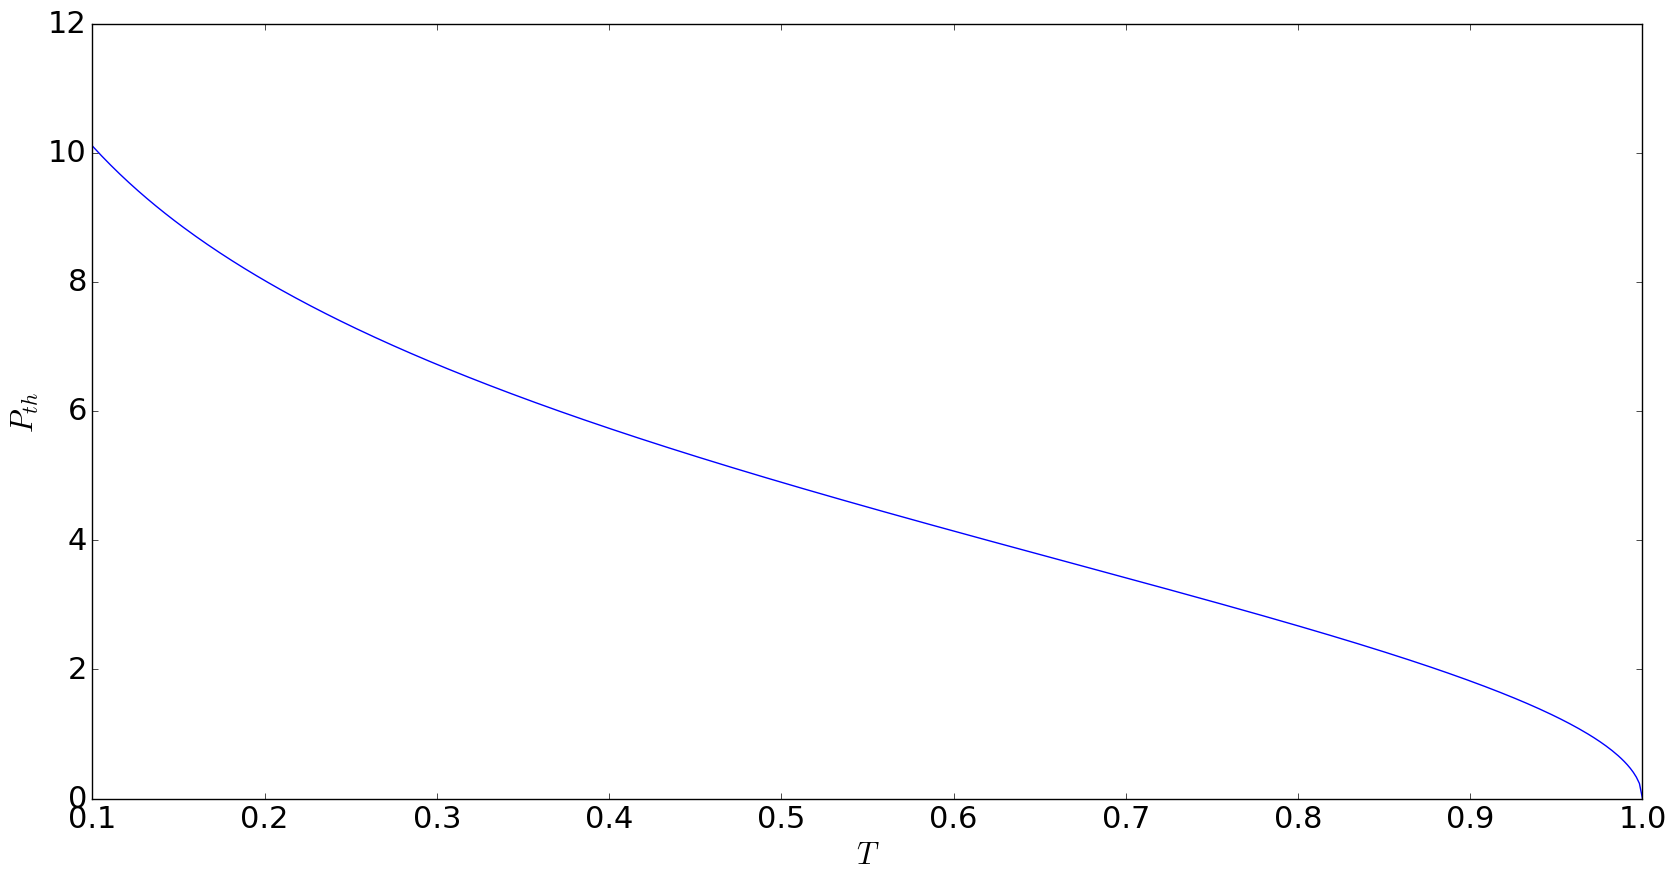

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import acosh
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 22}
matplotlib.rc('font', **font)

acosh = np.vectorize(acosh)
g = 10e-3
#g = 0.00092795
L = 18
T = np.linspace(0.1,1,512)



def P_th(T, g , L):
    a = (g*L)**(-1)
    b = acosh(np.sqrt(T)**(-1))
    return a*b

P = P_th(T,g,L)
print(' the paper quotes:', P_th(0.72,g,L), P_th(0.68,g,L), 'threshold powers for transmitance of:', 0.72, 0.68,'at wavelengths of 930nm and 940 nm respectively')

fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(T,P)
plt.xlabel(r'$T$')
plt.ylabel(r'$P_{th}$')
plt.show()

In [15]:
def find_P_th(T, P_find, g, L):
    return np.abs(P_th(T, g,L) - P_find)

#### The paper quotes theoretical threshold powers at:

In [16]:
a = fsolve(find_P_th, 0.72, args = (3.3, g,L),xtol = 1e-13)
print('Transmittance of',a[0])

Transmittance of 0.716160016284


In [17]:
a = fsolve(find_P_th, 0.68, args = (3.6, g,L),xtol = 1e-12)
print('Transmittance of',a[0])

Transmittance of 0.674732770867


##### While mine finds:


In [18]:
a = fsolve(find_P_th, 0.68, args = (5.5, g,L),xtol = 1e-12)
print('Transmittance of',a[0])

Transmittance of 0.426402309857


This is very different!!!

**Hypothesis**:

From the above we can see that the approximate 5.5W that we see as the threshold power in the model can be attributed to high losses in the system. I need to make sure I have the same transmition as the paper quotes that... changes with wavelength. 

# The problem of loss
It seems that due to the many splice losses I am expiriencing a larger threshold power. 
If the dB in loss is found by:

$$
L = 10 log \left( \frac{P_{out}}{P_{in}} \right)
$$

Then the Transmitence can be found by:

$$
T  =  \frac{P_{out}}{P_{in}} = 10^{\frac{L}{10}}
$$
under I will have some python code with examples.


In [6]:
def Trans(L):
    return 10 **(L / 10)

In [7]:
L  = np.linspace(-50, -0.001)

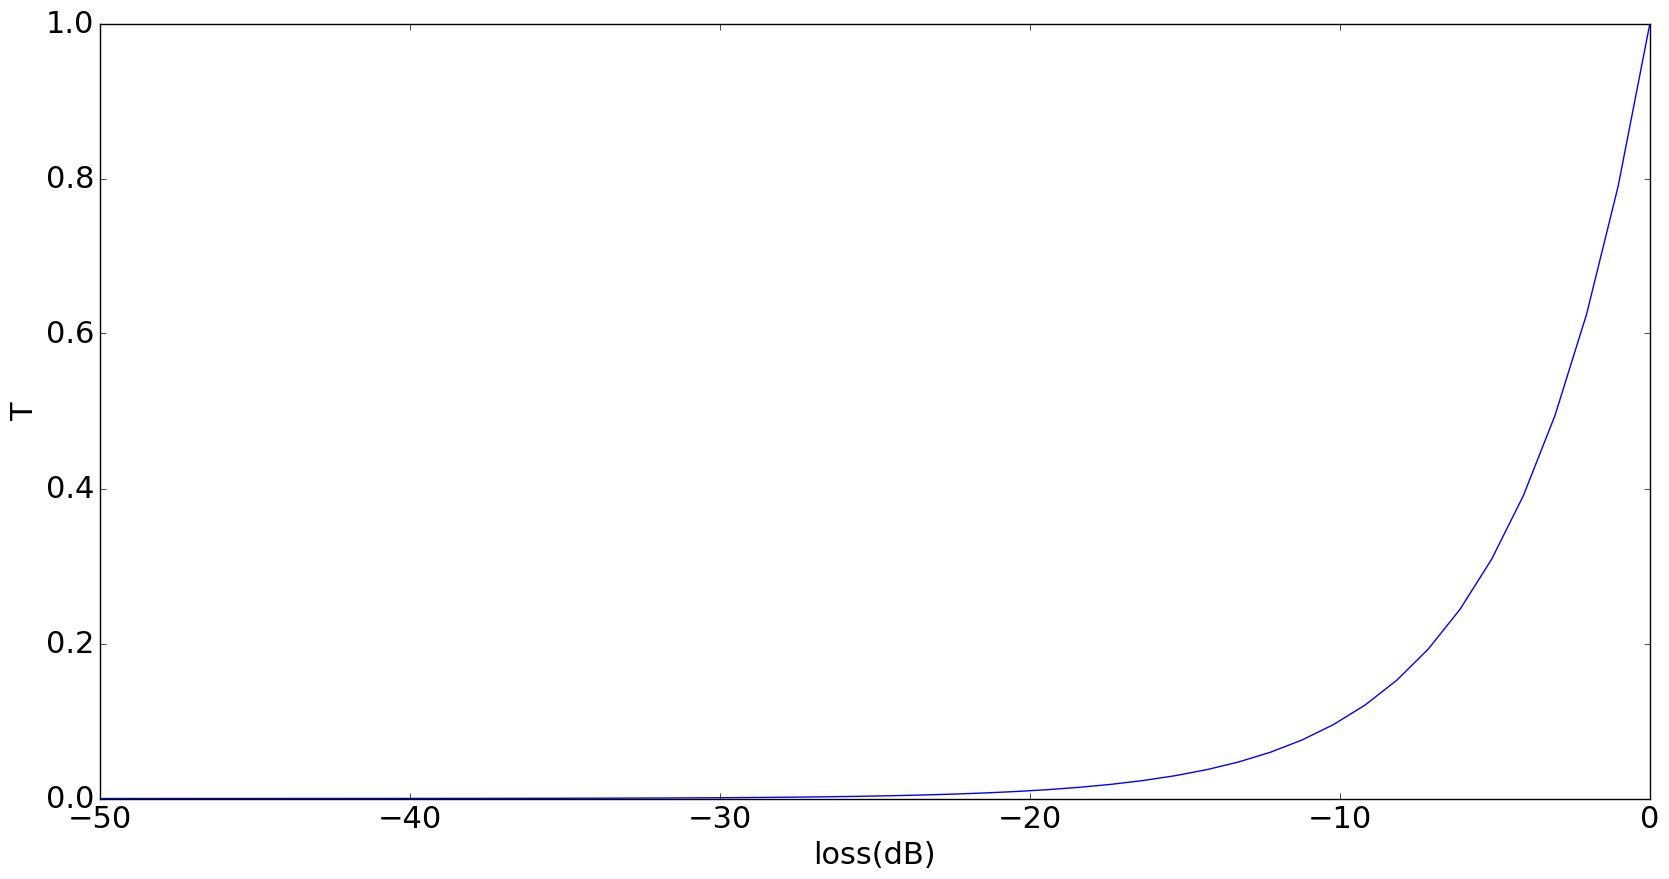

In [8]:
fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(L,Trans(L))
plt.xlabel('loss(dB)')
plt.ylabel('T')
plt.show()

#### So I am going to use the losses of both the WDM's and the splice losses

In [171]:
# Define splice losses
l1, l2 = 0.4895,0
#l1, l2 = 10,0

In [172]:
%matplotlib inline

In [173]:
lv = np.linspace(900, 1300,1024)

In [174]:
from functions import *
WDM1 = WDM(1200, 1050,lv)
WDM2 = WDM(930, 1200, lv)
WDM3 = WDM(930, 1050,lv)
WDM4 = WDM(930, 1200,lv)


In [175]:
def db(x):
    return 10*np.log10(x)

def wdm_losses(l):
    return db(WDM1.il_port2(l)) + db(WDM2.il_port2(l)) + db(WDM3.il_port2(l)) + db(WDM3.il_port2(l))


def total_loss(l, l1,l2):
    return  -2*l1 + -7*l2 + wdm_losses(l) - 0.021

def totalT(l,l1, l2):
    return 10**(total_loss(l,l1,l2)/10)

In [176]:
wdm_losses(930) - wdm_losses(940) 

0.51348820845687571

In [177]:
10**(totalT(930,l1, l2)/10) - 10**(totalT(940,l1, l2)/10)

0.021567553652585225

In [178]:
P_th(totalT(930,l1, l2), g,L)

3.2831269865199477

In [179]:
totalT(930,l1, l2)

0.71847663786403793

In [180]:
print('transmition at 930, and 940 is: '+str(totalT(930,l1, l2))+', '+str(totalT(940,l1, l2))+ ' diference: '+ str(totalT(930,l1, l2) - totalT(940,l1, l2))+' giving '+str(P_th(totalT(930,l1, l2), g,L))+' '+str(P_th(totalT(940,l1, l2), g,L)))

transmition at 930, and 940 is: 0.718476637864, 0.638357301585 diference: 0.0801193362786 giving 3.28312698652 3.86270234374


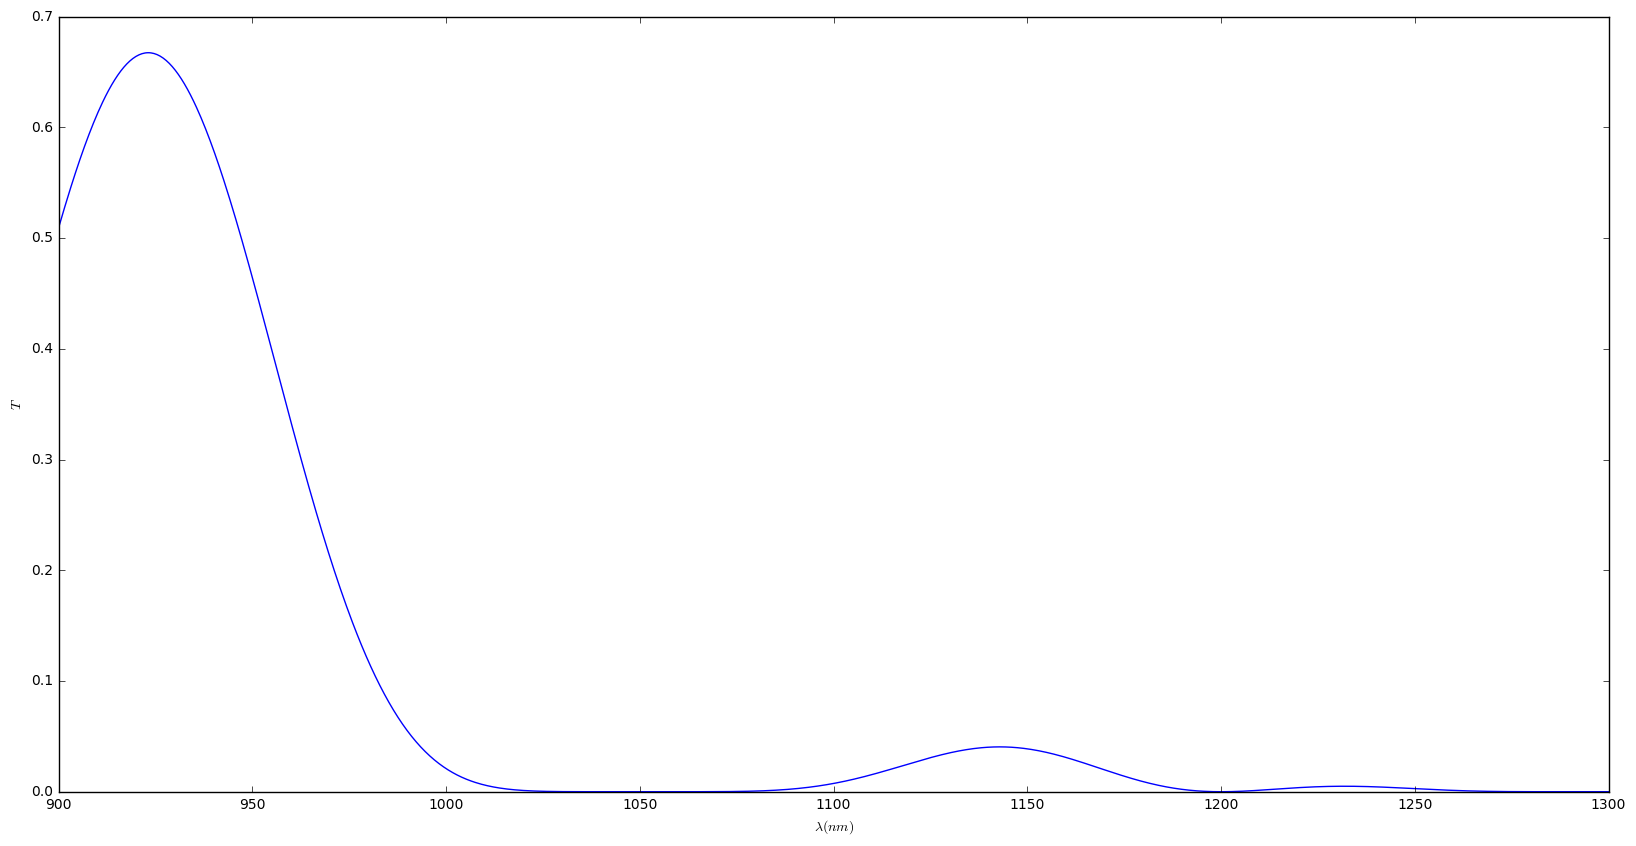

In [168]:
fig = plt.figure(figsize=(20.0, 10.0))
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(lv, totalT(lv,l1, l2))
plt.xlabel(r'$\lambda(nm)$')
plt.ylabel(r'$T$')

plt.show()

##### Clearly my transmittance is  low to get those good threshold powers. 
But the paper quotes: 3.2720235024 W 3.56197188739 W threshold powers for transmitance of: 0.72 0.68 at wavelengths of 930nm and 940 nm respectively. So all we need to do is solve/minimize totalT(l,l1, l2) and that would give us the splice losses of the system.
i.e.:

$$
totalT(930,l1, l2) = 0.72
$$

and

$$
totalT(940,l1, l2) = 0.68
$$


In [19]:
def solve_T(l_v):
    l1,l2 = l_v
    return (totalT(930,l1, l2) - 0.716160016284, totalT(940,l1, l2) - 0.674732770867)
    

In [20]:
l1,l2 = fsolve(solve_T, (0.157012903514,0.1),xtol = 1e-6)
print(l1,l2)

-271.126704118 77.5903176693


/home/john/miniconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [21]:
l1 = np.linspace(0, 0.2)
l2 = np.linspace(0,0.2)

In [22]:
L1,L2 = np.meshgrid(l1,l2)

In [23]:
z = solve_T((L1,L2))

In [24]:
np.min(z)

-0.14633152826191631

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

In [26]:
%matplotlib inline

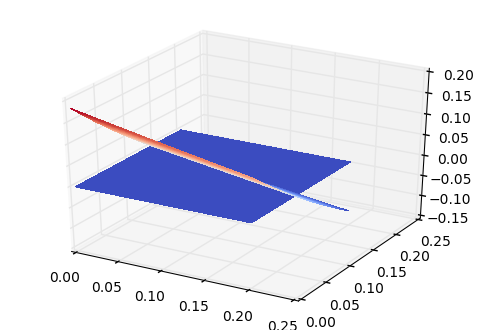

In [27]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(L1, L2, z[0], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot_surface(L1, L2, np.zeros_like(z[0]), rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

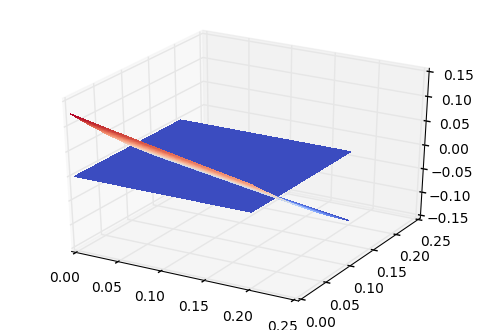

In [28]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(L1, L2, z[1], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot_surface(L1, L2, np.zeros_like(z[0]), rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

# Metting 6/1/2017

He is ok with what I am doing validate the model and then produce papers.


# input on 6/1/2017
since we have established that the total loss with respect to wavelength is found by:
$$
L_{t} = -2l_{1} - 7l_{2} + WDM^{(1)}_{p2}\left(\lambda \right) + WDM^{(2)}_{p2}\left(\lambda \right) + WDM^{(3)}_{p2}\left(\lambda \right) + WDM^{(4)}_{p2}\left(\lambda \right) = -2l_{1} - 7l_{2} + \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(\lambda \right)\right)
$$

, with $l1, l2 >0$ and the transmitence is found by:

$$
T\left(\lambda \right)  = 10 ^{\frac{L_{t}\left(\lambda \right)}{10}}
$$

Then the splice losses can be found by solving:

$$
2l_{1} + 7l_{2} = \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(\lambda \right)\right) - 10\log\left(T\left(\lambda \right)\right)
$$

Now as stated above the paper quotes two transmitences at two seperate wavelengths. This allows us to calculate the splice losses by solving the coupled linear equations of:


$$
2l_{1} + 7l_{2} = \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(930 \right)\right) - 10\log\left(0.72\right)
$$

$$
2l_{1} + 7l_{2} = \sum_{i=1}^{4} \left(WDM^{(i)}_{p2}\left(940 \right)\right) - 10\log\left(0.68\right)
$$
sollution down here in python using numpy linalg solve.

In [29]:
def rhs(lamda, T):
    return wdm_losses(lamda) - 10 * np.log10(T)

In [30]:
a = np.array([[2,7],[2,7]])
b = np.array([rhs(930, 0.72),rhs(940, 0.68)])

In [31]:
x = np.linalg.solve(a,b)

LinAlgError: Singular matrix

# OK SO THAT WAS WRONG!
It is because Zlobina quotes the tansmitance within the god damn cavity! FFS!

Firstly she quotes $1.4 dB$ loss within the cavity for a wavelength of $1205nm$ with $1dB$ being given to the loss of the fibre and the PCF losses. 

There are two PCF splice losses in that system and she quotes the fibre loss of $a_{L} \cdot L = 0.021dB$ hence:

$$
2 \cdot l_{1} + a_{L} \cdot L = 1 \Rightarrow l_{1} = \frac{1 -  a_{L} \cdot L}{2} =  \frac{1 -   0.021}{2} = 0.4895 dB
$$.

Furthermore from this one can consider the second splice loss by taking the loss of the wdm 1, 2 for the signal as:
* port2 of WDM1
* port1 of WDM2

again as above but now with the ring (2 small splices) and the WDM losses with respect to the signal ports. 
The equation to be solved is then:

$$
2 l_{1} + 2 l_{2}  = WDM^{(1)}_{p2}\left(1205 \right) + WDM^{(2)}_{p1}\left(1205 \right) - 10 \log \left(T\left(\lambda\right)\right) \Rightarrow
$$

$$
l_{2} = \frac{WDM^{(1)}_{p2}\left(1205 \right) + WDM^{(2)}_{p1}\left(1205 \right) - 10 \log \left(T\left(\lambda\right)\right) - 2 l_{1}}{2}
$$

In [189]:
WDM1 = WDM(1200, 1050,lv)
WDM2 = WDM(930, 1200, lv)

In [222]:
def l2(lamda, T, l1):
    num = WDM1.il_port1(lamda) + WDM2.il_port2(lamda) - 10 * np.log10(T) - 2*l1
    return num/2

In [223]:
print('the splice loss of the small loss ones is:', l2(1205, 0.72, 0.4895), 'dB')

the splice loss of the small loss ones is: 0.225630004434 dB


# To Do

make sure that you understand the ports correctly and that the loss of the other ones are correct